### DBSCAN (Density Based Spatial Clustering of Applications with Noise)

* 밀도 기반 군집화의 대표적인 알고리즘
* 간단하고 직관적인 알고리즘이지만, 데이터의 분포가 기하학적으로 복잡한 데이터 세트에도 효과적인 군집화가 가능

  
* **DBSCAN을 구성하는 중요한 파라미터**
    * 입실론(Epsilon) : 주변 영역이라고도 함. 개별 데이터를 중심으로 입실론 반경을 가지는 원형의 영역
    * 최소 데이터 개수(Min Point) : 개별 데이터의 입실론 주변 영역에 포함되는 타 데이터의 개수
      
        
* **주변 영역 내에 포함되는 최소 데이터의 갯수에 따라 다음과 같이 데이터 포인트를 정의함**
    * 핵심 포인트(Core Point) : 주변 영역내에 (최소 데이터 개수 < 이웃 포인트) 데이터를 가지고 있는 포인트
    * 이웃 포인트(Neighbor Point) :  주변 영역 내에 위치한 타 데이터
    * 경계 포인트(Border Point) : 주변 영역내에 (최소 데이터 개수 > 이웃 포인트), 단, 핵심 포인트를 이웃 포인트로 가지고 있는 데이터
    * 잡음 포인트(Noise Point) : 주변 영역내에 (최소 데이터 개수 > 이웃 포인트), 그리고 핵심 포인트도 없는 데이터
      
        
* **DBSCAN 알고리즘 동작원리**
    * 임의의 데이터가 핵심 포인트인지 구분한다
    * 해당 데이터가 핵심 포인트라면, 주변 영역 내에 또 다른 핵심 포인트가 있는지 살펴본다
    * 만약, 또 다른 핵심 포인트가 경계 내에 있다면, 서로 연결하여 군집화를 만든다
    * 이후 영역내에 다른 핵심 포인트가 없다면 경계 포인트를 찾아서 군집화의 경계로 설정한다
    * 즉, 입실론 주변 영역의 최소 데이터 개수를 포함하는 밀도 기준을 충촉시키는 데이터인 핵심 포인트를 연결하면서 군집화를 구성하는 방식임

### <붓꽃 품종을 DBSCAN으로 군집화>

In [3]:
from sklearn.datasets import load_iris
from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [4]:
iris = load_iris()
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

iris_df = pd.DataFrame(data=iris.data, columns=feature_names)
iris_df['target'] = iris.target

In [5]:
dbscan = DBSCAN(eps=0.6, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

iris_df['dbscan_cluster'] = dbscan_labels

iris_result = iris_df.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

target  dbscan_cluster
0        0                49
        -1                 1
1        1                46
        -1                 4
2        1                42
        -1                 8
Name: dbscan_cluster, dtype: int64


###     <1차 군집 결과>
* 군집화 결과, 0과 1외에 특이하게 -1이 군집 레이블로 있음
* -1은 노이즈에 속하는 군집임
* Target 값이 3인데 2개로 군집화 되었다고 효율이 떨어진다는 의미는 아님 DBSCAN은 굱비의 개수를 알고리즘에 따라 자동으로 지정함
    * 따라서 DBSCAN에서 군집의 개수를 지정하는 것은 무의미함
    * 군집을 3개로 하는 것보다는 2개로 하는 것이 군집화의 효율로서 더 좋은 면이 있음
* 군집화 데이터 세트를 2차원 평면에서 표현하기 위해 PCA를 이용해서 2개의 피처로 압축 변환한 뒤, visualize_cluster_plot()함수를 이용해 시각화

In [6]:
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    temp_df = dataframe
    target_list = np.unique(temp_df[label_name])
    
    if iscenter==True:
        centers = clusterobj.cluster_centers_
    
    markers=['o', 's', '^', 'P', 'D', 'H', 'x']
    
    for target in target_list:
        target_cluster = temp_df[temp_df[label_name]==target]
        plt.scatter(x=target_cluster['ftr1'], y=target_cluster['ftr2'], edgecolor='K', marker=markers[target])
        
        if iscenter==True:
            center_x_y = centers[target]         
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='white', alpha=0.9, edgecolor='k', marker=markers[target])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k', marker='$%d$' % target)
    
    plt.show()

<ipython-input-6-bd27934a838a>:12: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  plt.scatter(x=target_cluster['ftr1'], y=target_cluster['ftr2'], edgecolor='K', marker=markers[target])


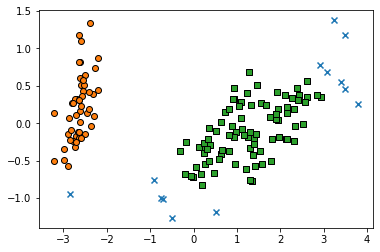

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
pca_transformed = pca.fit_transform(iris.data)

iris_df['ftr1'] = pca_transformed[:, 0]
iris_df['ftr2'] = pca_transformed[:, 1]

visualize_cluster_plot(dbscan, iris_df, 'dbscan_cluster', iscenter=False)

### DBSCAN의 주의점
* DBSCAN을 적용할 때는 특정 군집 개수로 군집을 강제하지 않는 것이 좋음
* 일반적으노 eps값을 크게 하면 반경이 커져서 포함하는 데이터가 많아짐 -> 노이즈 데이터 갯수 작아짐
* min_samples를 크게하면 포함해야하는 반경의 데이터가 많아야 하므로 노이즈 데이터 갯수 많아짐
    * 데이터 밀도가 더 커져야 하는데 매우 촘촘한 데이터 분포가 아닌 경우 노이즈로 인식

### eps=0.8, min_samples=8일경우

target  dbscan_cluster
0        0                50
1        1                50
2        1                47
        -1                 3
Name: dbscan_cluster, dtype: int64


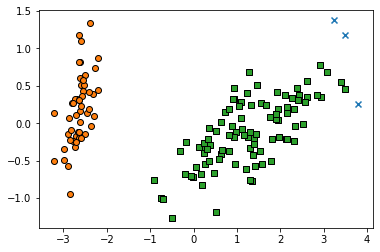

In [15]:
dbscan = DBSCAN(eps=0.8, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

iris_df['dbscan_cluster'] = dbscan_labels
iris_df['target'] = iris.target

iris_result = iris_df.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

visualize_cluster_plot(dbscan, iris_df, 'dbscan_cluster', None)

### eps=0.6, min_samples=16일경우

target  dbscan_cluster
0        0                48
        -1                 2
1        1                44
        -1                 6
2        1                36
        -1                14
Name: dbscan_cluster, dtype: int64


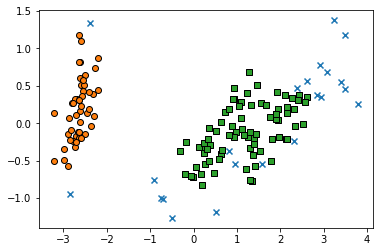

In [16]:
dbscan = DBSCAN(eps=0.6, min_samples=16, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

iris_df['dbscan_cluster'] = dbscan_labels
iris_df['target'] = iris.target

iris_result = iris_df.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

visualize_cluster_plot(dbscan, iris_df, 'dbscan_cluster', None)